<center><a href="https://www.nvidia.cn/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 3b. OCR 工作流

如今，许多大语言模型（LLM）系统可以从各类媒体中提取洞察，比如新闻文章和学术论文。这些来源包含多模态数据，如文本、图形和表格。本教程提供了一个分步指南，展示如何从多模态 PDF 文档中提取不同的模态。分析图像中的文本过程称为光学字符识别，简称 OCR。让我们创建一个融合 OCR 和其它 PDF 数据提取技术的多模态工作流，以便在 LLM 中使用。这种提取信息的 LLM 工作流，被称为检索增强生成或 RAG（Retrieval-Augmented Generation）。

<img src="images/DLI_extract.png" width="600">

这个教程使用开源的 [unstructured](https://github.com/Unstructured-IO/unstructured) 库预处理 PDF 文档中的图像、表格和文本。


#### 学习目标

本 notebook 的目标是：
* 探索文本分块（text chunking）
* 探索表格提取
* 探索图像/图表提取
* 探索使用 YOLOX-L 识别页面元素
* 创建一个端到端的多模态数据提取工作流

让我们先加载一些库。

In [1]:
import os
import getpass
import ipyplot
import requests
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image as IPyImage
from IPython.display import IFrame

from pathlib import Path

IMG_DIR = "ocr/images"

## 3.1 设置

本 notebook 将使用一门 DLI 课程的 Datasheet。它包含表格、图像和文本描述。请运行下面的单元，大致浏览一下文件内容。

In [2]:
datasheet_filename = "data/dli-model-parallelism-datasheet.pdf"
IFrame(datasheet_filename, width=800, height=500)

我们使用 `unstructured` 的 `partition_pdf` 函数来切分 PDF 文档，并提取其文本。当文本在 PDF 格式中不可用时，将使用光学字符识别（OCR）处理图像。它用的是 [Tesseract OCR](https://github.com/tesseract-ocr/tesseract) 工具。

In [3]:
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Text, Image, Table, CompositeElement

可以在 PDF 文件上直接使用 `partition_pdf` 来提取有用的元素。每个元素都是一段文本。

In [4]:
elements = partition_pdf(datasheet_filename)
print("Retrieved elements: ", len(elements))

Retrieved elements:  79


为了了解这些元素都长什么样，打印每个元素及其对应的页码。

In [5]:
for el in elements:
    if isinstance(el, Text):
        print("page ", el.metadata.page_number)
        print(el.text.strip())

page  1
Datasheet
page  1
Model Parallelism: Building and Deploying Large Neural Networks NVIDIA Deep Learning Institute
page  1
Workshop Overview
page  1
Learning Objectives
page  1
Large language models (LLMs) and deep neural networks (DNNs), whether
page  1
applied to natural language processing (e.g., GPT-3), computer vision (e.g.,
page  1
huge Vision Transformers), or speech AI (e.g., Wave2Vec 2), have certain
page  1
By participating in this workshop, you’ll learn how to:
page  1
properties that set them apart from their smaller counterparts. As LLMs
page  1
and DNNs become larger and are trained on progressively larger datasets,
page  1
they can adapt to new tasks with just a handful of training examples,
page  1
> Scale training and deployment of LLMs and neural networks across multiple nodes
page  1
accelerating the route toward general artificial intelligence. Training
page  1
models that contain tens to hundreds of billions of parameters on vast
page  1
datasets isn’t trivia

## 3.2 探索文本分块

文本分块是指将 PDF 中的文本数据转换成较小的块，这样可以做嵌入和存储以便后续检索。该库提供了一种基于分块大小参数（最大字符数）的朴素分块策略。这种方法是纯基于语法的，如果分块之间的语义不够明显，可能会限制 RAG 工作流的性能。

还有一种更精细的 `by_title` 分块策略，在这种策略下，章节边界得以保留，使文本能被拆分为更具语义区分度的片段。下面就来看看这种精细分块策略：

In [6]:
granular_elements = partition_pdf(
    datasheet_filename,
    chunking_strategy="by_title",
    max_characters=2000,
    new_after_n_chars=1800,
    combine_text_under_n_chars=1000,
)

先看看检测到了多少个文本段：

In [7]:
# check how many text section detected
print("Retrieved granular elements: ", len(granular_elements))

Retrieved granular elements:  5


接下来，对比一下两种方法提取的第一个文本段：

In [8]:
# let's compare extracted section 1 for both methods
print("Naive chunking method: \t", elements[0].text.strip()[:200], end="\n\n")
print("Granular chunking method: \t", granular_elements[0].text.strip()[:200], "...")

Naive chunking method: 	 Datasheet

Granular chunking method: 	 Datasheet

Model Parallelism: Building and Deploying Large Neural Networks NVIDIA Deep Learning Institute

Workshop Overview

Learning Objectives

Large language models (LLMs) and deep neural networks ...


可以看到，精细分块方法从 PDF 中提取并组合了语义连贯的文本段。这会对我们的 OCR 工作流检索过程有帮助。

## 3.3 探索表格提取
[unstructured](https://unstructured.io/) 库使用基于 transformer 的目标检测模型 [microsoft/table-transformer-structure-recognition](https://huggingface.co/microsoft/table-transformer-structure-recognition) 从 PDF 中提取表格。

为此，需要将 `infer_table_structure` 设置为 True。

<div class="alert alert-warning">运行下面的单元大约需要 22 秒</div>

In [9]:
%%time
table_text_elements = partition_pdf(
    datasheet_filename, infer_table_structure=True, strategy="hi_res"
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

CPU times: user 57.7 s, sys: 1.74 s, total: 59.5 s
Wall time: 12.3 s


`text_as_html` 元素的元数据（metadata）属性允许我们直接查看其对应的 HTML。

In [10]:
for el in table_text_elements:
    if type(el) == Table:
        print("Table")
        print(el.metadata.text_as_html) 
        el_html = el.metadata.text_as_html

Table
<table><tbody><tr><td>Duration</td><td>8 hours</td></tr><tr><td>Price</td><td>Contact us for pricing.</td></tr><tr><td rowspan="3">Prerequisites</td><td>&gt; Good understanding of PyTorch</td></tr><tr><td>&gt; Good understanding of deep learning and data parallel training concepts</td></tr><tr><td>&gt; Practice with multi-GPU training and natural language processing are useful, but optional</td></tr><tr><td>Tools, libraries, and frameworks</td><td>PyTorch, NVIDIA NeMo™ Framework, DeepSpeed, Slurm, TensorRT-LLM, NVIDIA Nsight™</td></tr><tr><td>Assessment type</td><td>Skills-based coding assessments evaluate learners’ ability to train deep learning models on multiple GPU:</td></tr><tr><td rowspan="2">Certificate</td><td>Upon successful completion of the assessment, participants will receive an NVIDIA DLI certificate to</td></tr><tr><td>recognize their subject matter competency and support professional career growth.</td></tr><tr><td rowspan="2">Hardware Requirements Language</td><t

接下来将这些信息转为可以被 [LangChain](https://python.langchain.com/docs/introduction/) 接收的 HTML 数据，LangChain 是一个用来创建 LLM 应用的流行框架。

In [11]:
from langchain.docstore.document import Document

table_elements = [
    Document(
        page_content=e.metadata.text_as_html,
        metadata={"filename": e.metadata.filename, "source_type": "table_html"},
    )
    for e in table_text_elements
    if type(e) == Table
]

# check first element
first_table_element = table_elements[0].page_content
first_table_element

'<table><tbody><tr><td>Duration</td><td>8 hours</td></tr><tr><td>Price</td><td>Contact us for pricing.</td></tr><tr><td rowspan="3">Prerequisites</td><td>&gt; Good understanding of PyTorch</td></tr><tr><td>&gt; Good understanding of deep learning and data parallel training concepts</td></tr><tr><td>&gt; Practice with multi-GPU training and natural language processing are useful, but optional</td></tr><tr><td>Tools, libraries, and frameworks</td><td>PyTorch, NVIDIA NeMo™ Framework, DeepSpeed, Slurm, TensorRT-LLM, NVIDIA Nsight™</td></tr><tr><td>Assessment type</td><td>Skills-based coding assessments evaluate learners’ ability to train deep learning models on multiple GPU:</td></tr><tr><td rowspan="2">Certificate</td><td>Upon successful completion of the assessment, participants will receive an NVIDIA DLI certificate to</td></tr><tr><td>recognize their subject matter competency and support professional career growth.</td></tr><tr><td rowspan="2">Hardware Requirements Language</td><td>Des

我们可以像浏览器一样在这个 Jupyter notebook 中渲染这些 HTML 内容。

In [12]:
# print the table as HTML
from IPython.core.display import HTML
from IPython.display import display
display(HTML(first_table_element))

大部分表格内容能被准确提取，但会有一些格式和细节的错误。我们可以将 PDF 转换为 markdown 格式，再用检索 markdown 形式的技术来提高提取的性能，或者把表格提取为图像，接下来就会讨论。

## 3.4 探索图像/图表提取

要从 PDF 中提取图像，我们可以设置 `extract_images_in_pdf=True`。`unstructured` 库使用 [YOLOX](https://arxiv.org/pdf/2107.08430v2) 模型来检测图像。YOLOX 是无锚（anchor-free）版本的 YOLO（You Only Look Once），来自 Megvii Technology 的一系列一次性目标检测模型。

```
elements = partition_pdf(filename=datasheet_filename,
                     strategy="hi-res",
                     hi_res_model_name="yolox")
```

<div class="alert alert-warning">运行下一个单元大约需要 12 秒。</div>

In [13]:
os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "yolox"

In [14]:
image_text_elements = partition_pdf(
    filename=datasheet_filename,                 
    strategy="hi_res",    
    hi_res_model_name="yolox",
    extract_images_in_pdf=True,                            
    extract_image_block_types=["Image"],          
    extract_image_block_to_payload=False,
    extract_image_block_output_dir=IMG_DIR
)

检查以下输出，确认图像提取出来了。

In [15]:
images = [e.metadata.image_path for e in image_text_elements if type(e) is Image]
print("list of extracted images:\n", images)

list of extracted images:
 ['ocr/images/figure-1-1.jpg', 'ocr/images/figure-2-2.jpg']


下面创建一个可视化图像的函数：

In [16]:
def plot_images_from_folder(folder_path=None, image_files=None):
    if image_files == None:
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    if image_files:
        ipyplot.plot_images(image_files, max_images=20, img_width=200, show_url=False)
    else:
        print("No images found in the specified folder.")

In [17]:
plot_images_from_folder(image_files=images)

我们还可以使用 YOLOX 模型处理表格。表格将以图像形式提取出来。

使用 `extract_image_block_types = ["Table"]`
<div class="alert alert-warning">运行下一个单元大约需要 16 秒。</div>

In [18]:
%%time
image_table_text_elements = partition_pdf(
    filename=datasheet_filename,                 
    strategy="hi_res",    
    hi_res_model_name="yolox",
    infer_table_structure=True,
    extract_images_in_pdf=True,                            
    extract_image_block_types=["Image", "Table"],          
    extract_image_block_to_payload=False,                  
    extract_image_block_output_dir=IMG_DIR
)

CPU times: user 1min, sys: 79.8 ms, total: 1min
Wall time: 7.5 s


`unstructured` 有一个 `elements_to_json` 函数，能将表格信息转成 [JSON](https://www.json.org/json-en.html) 文件。

In [19]:
import json
from IPython.display import display, Markdown
from unstructured.staging.base import elements_to_json

tables = [e for e in image_table_text_elements if isinstance(e, Table)]
json_data = elements_to_json(image_table_text_elements)
display(Markdown(f"```json\n{json.dumps(json.loads(json_data), indent=4, ensure_ascii=False)}\n```"))

```json
[
    {
        "element_id": "b198b6605dc50e3d683bdbf667046511",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1080.0,
                        -2.9
                    ],
                    [
                        1080.0,
                        603.3
                    ],
                    [
                        1703.3,
                        603.3
                    ],
                    [
                        1703.3,
                        -2.9
                    ]
                ],
                "system": "PixelSpace"
            },
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "image_path": "ocr/images/figure-1-1.jpg",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1
        },
        "text": "",
        "type": "Image"
    },
    {
        "element_id": "8511ed23615858f7b7ca8a0ea882cc69",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        92.0
                    ],
                    [
                        100.0,
                        126.0
                    ],
                    [
                        236.9,
                        126.0
                    ],
                    [
                        236.9,
                        92.0
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.51528,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1
        },
        "text": "Datasheet",
        "type": "Header"
    },
    {
        "element_id": "2d8f16613f30ebeaacdae420c1f48ce4",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        97.5,
                        167.8
                    ],
                    [
                        97.5,
                        226.7
                    ],
                    [
                        367.0,
                        226.7
                    ],
                    [
                        367.0,
                        167.8
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.48221,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "@INVIDIA.",
        "type": "Title"
    },
    {
        "element_id": "b007cad7820120bc5f6ebab7a3b415ee",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        98.2,
                        317.3
                    ],
                    [
                        98.2,
                        547.0
                    ],
                    [
                        989.5,
                        547.0
                    ],
                    [
                        989.5,
                        317.3
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.66596,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Model Parallelism: Building and Deploying Large Neural Networks",
        "type": "Title"
    },
    {
        "element_id": "5151cec42d9645da4e7ddb8f96c7d37f",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        571.1
                    ],
                    [
                        100.0,
                        610.0
                    ],
                    [
                        668.3,
                        610.0
                    ],
                    [
                        668.3,
                        571.1
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.58741,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "b007cad7820120bc5f6ebab7a3b415ee"
        },
        "text": "NVIDIA Deep Learning Institute",
        "type": "NarrativeText"
    },
    {
        "element_id": "23287339d66b3ed4e38fed130fa64dc2",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        99.4,
                        672.1
                    ],
                    [
                        99.4,
                        705.5
                    ],
                    [
                        416.8,
                        705.5
                    ],
                    [
                        416.8,
                        672.1
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.84316,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Workshop Overview",
        "type": "Title"
    },
    {
        "element_id": "d58190e04aefb1315971dada8baaf462",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1108.3,
                        691.7
                    ],
                    [
                        1108.3,
                        731.3
                    ],
                    [
                        1423.6,
                        731.3
                    ],
                    [
                        1423.6,
                        691.7
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.77267,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Learning Objectives",
        "type": "Title"
    },
    {
        "element_id": "07af56eaf8c8589220e61078504f914e",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        99.6,
                        727.5
                    ],
                    [
                        99.6,
                        1182.6
                    ],
                    [
                        967.6,
                        1182.6
                    ],
                    [
                        967.6,
                        727.5
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.942,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "d58190e04aefb1315971dada8baaf462"
        },
        "text": "Large language models (LLMs) and deep neural networks (DNNs), whether applied to natural language processing (e.g., GPT-3), computer vision (e.g., huge Vision Transformers), or speech AI (e.g., Wave2Vec 2), have certain properties that set them apart from their smaller counterparts. As LLMs and DNNs become larger and are trained on progressively larger datasets, they can adapt to new tasks with just a handful of training examples, accelerating the route toward general artificial intelligence. Training models that contain tens to hundreds of billions of parameters on vast datasets isn’t trivial and requires a unique combination of AI, high- performance computing (HPC), and systems knowledge. The goal of this course is to demonstrate how to train the largest of neural networks and deploy them to production.",
        "type": "NarrativeText"
    },
    {
        "element_id": "9a62a6251b64060fdbe01752d25a3f3f",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1108.3,
                        767.7
                    ],
                    [
                        1108.3,
                        825.1
                    ],
                    [
                        1516.8,
                        825.1
                    ],
                    [
                        1516.8,
                        767.7
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.74081,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "By participating in this workshop, you’ll learn how to:",
        "type": "Title"
    },
    {
        "element_id": "1e743aca2d22a502d750146c6398e458",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1108.3,
                        848.9
                    ],
                    [
                        1108.3,
                        949.8
                    ],
                    [
                        1533.2,
                        949.8
                    ],
                    [
                        1533.2,
                        848.9
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.88881,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f"
        },
        "text": "> Scale training and deployment of LLMs and neural networks across multiple nodes",
        "type": "ListItem"
    },
    {
        "element_id": "354ef16ecfa07b878f9856548ea68880",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1106.3,
                        975.9
                    ],
                    [
                        1106.3,
                        1184.3
                    ],
                    [
                        1550.7,
                        1184.3
                    ],
                    [
                        1550.7,
                        975.9
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.90522,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f"
        },
        "text": "> Use techniques such as activation checkpointing, gradient accumulation, and various forms of model parallelism to overcome the challenges associated with large- model memory footprint",
        "type": "ListItem"
    },
    {
        "element_id": "14e1d6843e3d8543189d0ed833881aa0",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1104.3,
                        1208.2
                    ],
                    [
                        1104.3,
                        1308.1
                    ],
                    [
                        1521.1,
                        1308.1
                    ],
                    [
                        1521.1,
                        1208.2
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.85965,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f"
        },
        "text": "> Capture and understand training performance characteristics to optimize model architecture",
        "type": "ListItem"
    },
    {
        "element_id": "5852b2b00b43dc956d75a086bd5c3b81",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1106.0,
                        1332.1
                    ],
                    [
                        1106.0,
                        1433.1
                    ],
                    [
                        1546.5,
                        1433.1
                    ],
                    [
                        1546.5,
                        1332.1
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.85715,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f"
        },
        "text": "> Deploy very large multi-GPU, multi- node models to production using NVIDIA TensorRT™-LLM",
        "type": "ListItem"
    },
    {
        "element_id": "1910363fc925b8f4f8e9b48a6f4d540e",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1511.7
                    ],
                    [
                        100.0,
                        2064.8
                    ],
                    [
                        1571.1,
                        2064.8
                    ],
                    [
                        1571.1,
                        1511.7
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.70349,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "image_path": "ocr/images/table-1-1.jpg",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f",
            "text_as_html": "<table><tbody><tr><td>Duration</td><td>8 hours</td></tr><tr><td>Price</td><td>Contact us for pricing.</td></tr><tr><td rowspan=\"3\">Prerequisites</td><td>&gt; Good understanding of PyTorch</td></tr><tr><td>&gt; Good understanding of deep learning and data parallel training concepts</td></tr><tr><td>&gt; Practice with multi-GPU training and natural language processing are useful, but optional</td></tr><tr><td>Tools, libraries, and frameworks</td><td>PyTorch, NVIDIA NeMo™ Framework, DeepSpeed, Slurm, TensorRT-LLM, NVIDIA Nsight™</td></tr><tr><td>Assessment type</td><td>Skills-based coding assessments evaluate learners’ ability to train deep learning models on multiple GPU:</td></tr><tr><td rowspan=\"2\">Certificate</td><td>Upon successful completion of the assessment, participants will receive an NVIDIA DLI certificate to</td></tr><tr><td>recognize their subject matter competency and support professional career growth.</td></tr><tr><td rowspan=\"2\">Hardware Requirements Language</td><td>Desktop or laptop computer capable of running the latest version of Chrome or Firefox. Each participant</td></tr><tr><td>will be provided with dedicated access to a fully configured, GPU-accelerated workstation in the cloud. English</td></tr></tbody></table>"
        },
        "text": "Overview Duration 8 hours Price Contact us for pricing. Prerequisites > Good understanding of PyTorch > Good understanding of deep learning and data parallel training concepts > Practice with multi-GPU training and natural language processing are useful, but optional PyTorch, NVIDIA NeMo™ Framework, DeepSpeed, Slurm, TensorRT-LLM, NVIDIA Nsight™ Tools, libraries, and frameworks Assessment type Certificate Upon successful completion of the assessment, participants will receive an NVIDIA DLI certificate to recognize their subject matter competency and support professional career growth. Hardware Requirements Desktop or laptop computer capable of running the latest version of Chrome or Firefox. Each participant will be provided with dedicated access to a fully configured, GPU-accelerated workstation in the cloud. Language English",
        "type": "Table"
    },
    {
        "element_id": "1bfc9ed76d149aad5214f3fad125ce35",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        487.5,
                        1837.7
                    ],
                    [
                        487.5,
                        1860.0
                    ],
                    [
                        1583.4,
                        1860.0
                    ],
                    [
                        1583.4,
                        1837.7
                    ]
                ],
                "system": "PixelSpace"
            },
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 1,
            "parent_id": "9a62a6251b64060fdbe01752d25a3f3f"
        },
        "text": "Skills-based coding assessments evaluate learners' ability to train deep learning models on multiple GPUs.",
        "type": "NarrativeText"
    },
    {
        "element_id": "276c0ce2df8b3c8a802df2abcf8c8452",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        116.7,
                        112.6
                    ],
                    [
                        116.7,
                        141.4
                    ],
                    [
                        333.5,
                        141.4
                    ],
                    [
                        333.5,
                        112.6
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.4001,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Workshop Outline",
        "type": "Title"
    },
    {
        "element_id": "8b8d53420668dd27cd97e52f3a0f61f5",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        112.6,
                        165.4
                    ],
                    [
                        112.6,
                        229.0
                    ],
                    [
                        273.0,
                        229.0
                    ],
                    [
                        273.0,
                        165.4
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.3841,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "276c0ce2df8b3c8a802df2abcf8c8452"
        },
        "text": "Introduction (15 minutes)",
        "type": "NarrativeText"
    },
    {
        "element_id": "9307c231d94f8292737ba35dd8982806",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        583.3,
                        165.4
                    ],
                    [
                        583.3,
                        190.4
                    ],
                    [
                        817.8,
                        190.4
                    ],
                    [
                        817.8,
                        165.4
                    ]
                ],
                "system": "PixelSpace"
            },
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Meet the instructor.",
        "type": "Title"
    },
    {
        "element_id": "4c9f94336fd631dddad6f6efcd0ef30e",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        583.3,
                        216.2
                    ],
                    [
                        583.3,
                        241.2
                    ],
                    [
                        1139.8,
                        241.2
                    ],
                    [
                        1139.8,
                        216.2
                    ]
                ],
                "system": "PixelSpace"
            },
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "> Create an account at courses.nvidia.com/join",
        "type": "Title"
    },
    {
        "element_id": "de77e8f9ff740f7c02d4b762d87f7005",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        113.9,
                        221.9
                    ],
                    [
                        113.9,
                        1280.8
                    ],
                    [
                        1552.0,
                        1280.8
                    ],
                    [
                        1552.0,
                        221.9
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.7506,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "image_path": "ocr/images/table-2-2.jpg",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "4c9f94336fd631dddad6f6efcd0ef30e",
            "text_as_html": "<table><tbody><tr><td rowspan=\"5\">Introduction to Training of Large Models (120 minutes)</td><td>Vv Learn about the motivation behind and key challenges of training large models.</td></tr><tr><td>Get an overview of the basic techniques and tools needed for large-scale training</td></tr><tr><td>Get an introduction to distributed training and the Slurm job scheduler.</td></tr><tr><td>Train a GPT model using data parallelism. vvvyv</td></tr><tr><td>Profile the training process and understand execution performance.</td></tr><tr><td colspan=\"2\">Break (60 minutes)</td></tr><tr><td>Model Parallelism: Advanced Topics</td><td>&gt; Increase the model size using a range of memory-saving techniques.</td></tr><tr><td rowspan=\"4\">(120 minutes)</td><td>&gt; Get an introduction to tensor and pipeline parallelism.</td></tr><tr><td>&gt; Go beyond natural language processing and get an introduction to DeepSpeed.</td></tr><tr><td>&gt; Auto-tune model performance</td></tr><tr><td>&gt; Learn about mixture-of-experts models.</td></tr><tr><td colspan=\"2\">Break (15 minutes)</td></tr><tr><td>Inference of Large Models</td><td>&gt; Understand the challenges of deployment associated with large models.</td></tr><tr><td>(90 minutes)</td><td>&gt; Explore techniques for model reduction.</td></tr><tr><td rowspan=\"3\"></td><td>&gt; Learn how to use TensorRT-LLM.</td></tr><tr><td>&gt; Understand the process of deploying GPT checkpoint to production.</td></tr><tr><td>&gt; See an example of prompt engineering.</td></tr><tr><td>Final Review</td><td>&gt; Review key learnings and answer questions.</td></tr><tr><td></td><td>&gt; Complete the assessment and earn a certificate.</td></tr><tr><td rowspan=\"2\">(15 minutes)</td><td>&gt; Complete the workshop survey.</td></tr><tr><td>&gt; Learn how to set up your own Al application development environment</td></tr><tr><td rowspan=\"4\">Next Steps</td><td>&gt; Building Conversational Al Applications</td></tr><tr><td>&gt; Data Parallelism: How to Train Deep Learning Models on Multiple GPUs</td></tr><tr><td>&gt; Building Transformer-Based Natural Language Processing Applications</td></tr><tr><td>&gt; Building RAG Agents for LLMs</td></tr></tbody></table>"
        },
        "text": "Introduction to Training of Large > Learn about the motivation behind and key challenges of training large models. Models > Get an overview of the basic techniques and tools needed for large-scale training. (120 minutes) > Get an introduction to distributed training and the Slurm job scheduler. > Train a GPT model using data parallelism. > Profile the training process and understand execution performance. Break (60 minutes) Model Parallelism: Advanced Topics > Increase the model size using a range of memory-saving techniques. (120 minutes) > Get an introduction to tensor and pipeline parallelism. > Go beyond natural language processing and get an introduction to DeepSpeed. > Auto-tune model performance > Learn about mixture-of-experts models. Break (15 minutes) Inference of Large Models > Understand the challenges of deployment associated with large models. (90 minutes) > Explore techniques for model reduction. > Learn how to use TensorRT-LLM. > Understand the process of deploying GPT checkpoint to production. > See an example of prompt engineering. Final Review > Review key learnings and answer questions. (15 minutes) > Complete the assessment and earn a certificate. > Complete the workshop survey. > Learn how to set up your own AI application development environment Next Steps > Building Conversational AI Applications > Data Parallelism: How to Train Deep Learning Models on Multiple GPUs > Building Transformer-Based Natural Language Processing Applications > Building RAG Agents for LLMs",
        "type": "Table"
    },
    {
        "element_id": "a0824d84df1f4102cdecdefa553df407",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1329.5
                    ],
                    [
                        100.0,
                        1362.8
                    ],
                    [
                        1196.6,
                        1362.8
                    ],
                    [
                        1196.6,
                        1329.5
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.90472,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Why Choose NVIDIA Deep Learning Institute for Hands-On Training?",
        "type": "Title"
    },
    {
        "element_id": "0ad25f0f0629c45416da931f95d8279e",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1381.3
                    ],
                    [
                        100.0,
                        1437.5
                    ],
                    [
                        1593.5,
                        1437.5
                    ],
                    [
                        1593.5,
                        1381.3
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.87593,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "a0824d84df1f4102cdecdefa553df407"
        },
        "text": "> Access workshops from anywhere with just your desktop/laptop and an internet connection. Each participant will have access to a fully configured, GPU-accelerated server in the cloud.",
        "type": "ListItem"
    },
    {
        "element_id": "b85ec094238814d41382cf698ae8310e",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1447.6
                    ],
                    [
                        100.0,
                        1475.8
                    ],
                    [
                        1379.4,
                        1475.8
                    ],
                    [
                        1379.4,
                        1447.6
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.85624,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "a0824d84df1f4102cdecdefa553df407"
        },
        "text": "> Obtain hands-on experience with the most widely used, industry-standard software, tools, and frameworks.",
        "type": "ListItem"
    },
    {
        "element_id": "0a9fcf6fd0f79fb45873f651711a8cc2",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1487.6
                    ],
                    [
                        100.0,
                        1543.0
                    ],
                    [
                        1435.1,
                        1543.0
                    ],
                    [
                        1435.1,
                        1487.6
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.90319,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "a0824d84df1f4102cdecdefa553df407"
        },
        "text": "> Learn to build deep learning and accelerated computing applications for industries, such as healthcare, robotics, manufacturing, accelerated computing, and more.",
        "type": "ListItem"
    },
    {
        "element_id": "cac697472f013928b3ca41461ee7f204",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1553.4
                    ],
                    [
                        100.0,
                        1582.5
                    ],
                    [
                        1112.9,
                        1582.5
                    ],
                    [
                        1112.9,
                        1553.4
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.84304,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "a0824d84df1f4102cdecdefa553df407"
        },
        "text": "> Gain real-world expertise through content designed by NVIDIA and industry experts.",
        "type": "ListItem"
    },
    {
        "element_id": "866ef89c6f6d6a21796499e0628570bd",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1593.1
                    ],
                    [
                        100.0,
                        1620.8
                    ],
                    [
                        1434.0,
                        1620.8
                    ],
                    [
                        1434.0,
                        1593.1
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.8452,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "a0824d84df1f4102cdecdefa553df407"
        },
        "text": "> Earn an NVIDIA DLI certificate to demonstrate your subject matter competency and support your career growth.",
        "type": "ListItem"
    },
    {
        "element_id": "f74416b54cb216ca0acb3bd555f937b4",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1838.3
                    ],
                    [
                        100.0,
                        1885.3
                    ],
                    [
                        513.3,
                        1885.3
                    ],
                    [
                        513.3,
                        1838.3
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.85269,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "Ready to Get Started?",
        "type": "Title"
    },
    {
        "element_id": "cf7384ede703cefd4ad92b08250e8ef3",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1900.5
                    ],
                    [
                        100.0,
                        1973.5
                    ],
                    [
                        793.5,
                        1973.5
                    ],
                    [
                        793.5,
                        1900.5
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.8706,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "f74416b54cb216ca0acb3bd555f937b4"
        },
        "text": "For the latest DLI workshops and trainings, visit www.nvidia.com/dli",
        "type": "NarrativeText"
    },
    {
        "element_id": "71e6a1e030ff92526f0d49b568427119",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        100.0,
                        1992.9
                    ],
                    [
                        100.0,
                        2028.3
                    ],
                    [
                        770.2,
                        2028.3
                    ],
                    [
                        770.2,
                        1992.9
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.67252,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "8511ed23615858f7b7ca8a0ea882cc69"
        },
        "text": "For questions, contact us at nvdli@nvidia.com",
        "type": "Title"
    },
    {
        "element_id": "be615fb640d050c680722aa1e70b04bb",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        99.9,
                        2043.3
                    ],
                    [
                        99.9,
                        2105.0
                    ],
                    [
                        933.7,
                        2105.0
                    ],
                    [
                        933.7,
                        2043.3
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.89033,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2,
            "parent_id": "71e6a1e030ff92526f0d49b568427119"
        },
        "text": "© 2024 NVIDIA Corporation. All rights reserved. NVIDIA, the NVIDIA logo, NeMo, Nsight, and TensorRT are trademarks and/or registered trademarks of NVIDIA Corporation in the U.S. and other countries. All other trademarks and copyrights are the property of their respective owners. 3187848. MAR24",
        "type": "NarrativeText"
    },
    {
        "element_id": "217999b203a8b3c13bde793903277b06",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1423.9,
                        1951.2
                    ],
                    [
                        1423.9,
                        2080.7
                    ],
                    [
                        1575.2,
                        2080.7
                    ],
                    [
                        1575.2,
                        1951.2
                    ]
                ],
                "system": "PixelSpace"
            },
            "detection_class_prob": 0.63769,
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "image_path": "ocr/images/figure-2-2.jpg",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2
        },
        "text": "",
        "type": "Image"
    },
    {
        "element_id": "42513912156d332f746f3b6a73a1606b",
        "metadata": {
            "coordinates": {
                "layout_height": 2200,
                "layout_width": 1700,
                "points": [
                    [
                        1411.0,
                        2065.0
                    ],
                    [
                        1411.0,
                        2101.0
                    ],
                    [
                        1608.0,
                        2101.0
                    ],
                    [
                        1608.0,
                        2065.0
                    ]
                ],
                "system": "PixelSpace"
            },
            "file_directory": "data",
            "filename": "dli-model-parallelism-datasheet.pdf",
            "filetype": "application/pdf",
            "languages": [
                "eng"
            ],
            "last_modified": "2025-04-01T03:36:45",
            "page_number": 2
        },
        "text": "NVIDIA.",
        "type": "UncategorizedText"
    }
]
```

虽然表格信息已经提出来了，但这种格式读起来比较困难。不过我们可以把表格当做图像来展示。

In [20]:
plot_images_from_folder(folder_path=IMG_DIR)

## 3.5 使用 NV-YOLOX 识别页面元素

YOLOX-L 是在 Digital Corpora 数据集的 26,000 张图像上微调的 YOLOX 版本，其中包括来自 Azure AI Document Intelligence 的注释。该模型旨在检测文档中的**表格**、**图表**和 **标题**。图表包括条形图、折线图或饼图。标题可以是页面标题、章节标题或表格/图表标题。

让我们用 [nvidia/nv-yolox-page-elements-v1](https://build.nvidia.com/nvidia/nv-yolox-page-elements-v1) 模型来定位 [PNG](https://en.wikipedia.org/wiki/PNG) 文件中元素的边界框。边界框能告诉我们元素在图像中的位置。下面是一张示例图像。

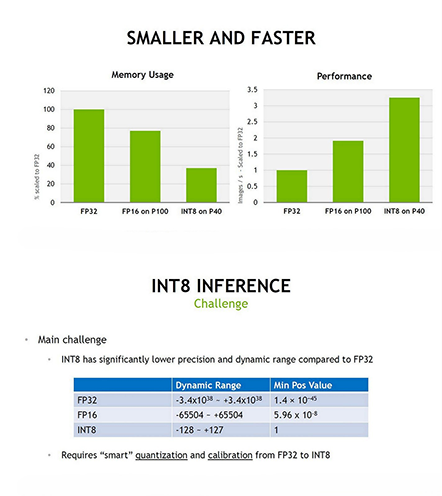

In [21]:
image_filename = "images/anchor_example_image.png"
IPyImage(filename=image_filename, width=400)

我们可以创建一个调用 YOLOX 模型 API 入口的函数，并返回页面元素及其在页面上的精确位置。

In [22]:
def run_yolox(filename):
    invoke_url = "http://ngc-client:9505/v1/cv/nvidia/nv-yolox-page-elements-v1"
    with open(filename, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
    assert len(image_b64) < 250_000, "To upload larger images, use the assets API (see docs)"
    
    headers = {
       "Authorization": "Bearer $API_KEY_REQUIRED_IF_EXECUTING_OUTSIDE_NGC",
       "Accept": "application/json"
    }
    
    payload = {
      "input": [
        {
          "type": "image_url",
          "url": f"data:image/png;base64,{image_b64}"
        }
      ]
    }
    
    response = requests.post(invoke_url, headers=headers, json=payload)
    print(response.json())
    bounding_boxes = response.json()['data'][0]['bounding_boxes']
    return bounding_boxes

现在可以调 `run_yolox` 测一下了。

In [23]:
bounding_boxes = run_yolox(image_filename)

{'data': [{'index': 0, 'bounding_boxes': {'table': [{'x_min': 0.1628, 'y_min': 0.7595, 'x_max': 0.8363, 'y_max': 0.8809, 'confidence': 0.9499}], 'chart': [{'x_min': 0.0722, 'y_min': 0.1365, 'x_max': 1.0, 'y_max': 0.4388, 'confidence': 0.8748}], 'title': [{'x_min': 0.2837, 'y_min': 0.0589, 'x_max': 0.716, 'y_max': 0.0914, 'confidence': 0.8215}, {'x_min': 0.0557, 'y_min': 0.6734, 'x_max': 0.2442, 'y_max': 0.6959, 'confidence': 0.5681}, {'x_min': 0.3398, 'y_min': 0.5595, 'x_max': 0.6579, 'y_max': 0.6269, 'confidence': 0.2829}]}}]}


In [24]:
bounding_boxes

{'table': [{'x_min': 0.1628,
   'y_min': 0.7595,
   'x_max': 0.8363,
   'y_max': 0.8809,
   'confidence': 0.9499}],
 'chart': [{'x_min': 0.0722,
   'y_min': 0.1365,
   'x_max': 1.0,
   'y_max': 0.4388,
   'confidence': 0.8748}],
 'title': [{'x_min': 0.2837,
   'y_min': 0.0589,
   'x_max': 0.716,
   'y_max': 0.0914,
   'confidence': 0.8215},
  {'x_min': 0.0557,
   'y_min': 0.6734,
   'x_max': 0.2442,
   'y_max': 0.6959,
   'confidence': 0.5681},
  {'x_min': 0.3398,
   'y_min': 0.5595,
   'x_max': 0.6579,
   'y_max': 0.6269,
   'confidence': 0.2829}]}

可以看到模型识别出了 3 种元素：表格，图表和标题（其中标题有 3 个）。

将这些由模型识别的元素周围的边界框可视化一下：

In [25]:
# plotting function
def plot_bounding_boxes(image, bounding_boxes):
    annotated_image = image.copy()
    height, width = image.shape[:2]
    color = (128, 128, 128)
    labels = ['table', 'chart', 'title']   
    for l in labels:
        # check if label is identified
        if l not in bounding_boxes:
            continue
        T = bounding_boxes[l]
        for t in T:
            x_min = int(width * t['x_min'])
            y_min = int(height * t['y_min'])
            x_max = int(width * t['x_max'])
            y_max = int(height * t['y_max'])
            label = f"{l} {t['confidence']:.2f}"
            color = (0, 255, 0)  # Green color for the box
            cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), color, 2, cv2.LINE_AA)
            cv2.putText(annotated_image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, color=color, thickness=1)
    return annotated_image

把边界框绘制出来，并将结果保存成一个临时图像。

In [26]:
image = cv2.imread(image_filename)
annotated_image = plot_bounding_boxes(image, bounding_boxes)
OUTPUT_IMAGE_PATH = "ocr/outputs/yolox"

libpng warning: iCCP: known incorrect sRGB profile


In [27]:
cv2.imwrite(OUTPUT_IMAGE_PATH + '/test_annotated.jpg', annotated_image)

True

现在我们就可以看看 `nv-yolox-page-elements-v1` 检测到的元素是什么样的了：

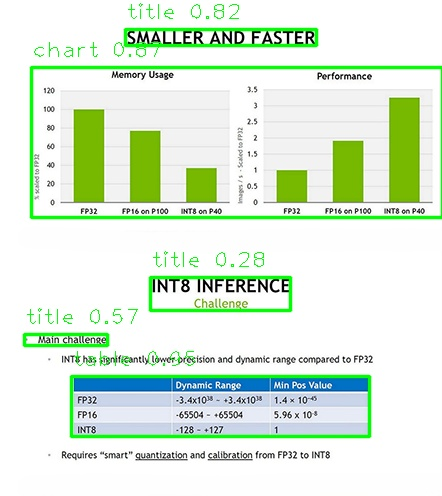

In [28]:
IPyImage(filename=OUTPUT_IMAGE_PATH + '/test_annotated.jpg', width=400)

## 3.5.1 练习：边界框（Bounding Box）

现在再用 DLI 课程的 Datasheet 试一下。

首先要将 PDF 的每一页转成图像，有几种方法可以实现。可以通过 `convert_from_path` 一次性处理整个 PDF，它会将所有页面加载到内存中：

```
from pdf2image import convert_from_path

pages = convert_from_path(datasheet_filename, 500)
for count, page in enumerate(pages):
    page.save(f'pdf2image/out_{count}.jpg', 'JPEG')
```

但这可能会占用大量内存，尤其是对那些较大的 PDF 和内存有限的系统。

其实我们可以分批处理，每次只加载 PDF的一部分内容到内存中。将 `CHUNK_SIZE` 根据可用系统资源进行调整。

In [29]:
from pdf2image import pdfinfo_from_path, convert_from_path

PATH_PDF2IMAGE = "ocr/outputs/pdf2image"

CHUNK_SIZE = 20  # depends on RAM
MAX_PAGES = pdfinfo_from_path(datasheet_filename)["Pages"]

pages = []
for page in range(1, MAX_PAGES, CHUNK_SIZE):
    pages += convert_from_path(datasheet_filename, first_page=page, last_page=page + CHUNK_SIZE - 1, dpi=110)

for count, page in enumerate(pages):
    page.save(f'{PATH_PDF2IMAGE}/test_{count}.jpg', 'JPEG')

确认一下图像块是不是已经创建出来了。

In [30]:
!ls $PATH_PDF2IMAGE

test_0.jpg  test_1.jpg


然后可视化一下。

In [31]:
# Now let's visualize the pages
plot_images_from_folder(folder_path=PATH_PDF2IMAGE)

我们可以挑一页来计算页面元素的边界框。

In [32]:
bounding_boxes = run_yolox(PATH_PDF2IMAGE + "/test_1.jpg")
image = cv2.imread(PATH_PDF2IMAGE + "/test_1.jpg")   
annotated_image = plot_bounding_boxes(image, bounding_boxes)
cv2.imwrite(OUTPUT_IMAGE_PATH + '/annotated_test_1.jpg', annotated_image)

{'data': [{'index': 0, 'bounding_boxes': {'table': [{'x_min': 0.0585, 'y_min': 0.0541, 'x_max': 0.9437, 'y_max': 0.5725, 'confidence': 0.9708}], 'title': [{'x_min': 0.0573, 'y_min': 0.8377, 'x_max': 0.3046, 'y_max': 0.8562, 'confidence': 0.8694}, {'x_min': 0.0576, 'y_min': 0.6017, 'x_max': 0.7039, 'y_max': 0.619, 'confidence': 0.8625}, {'x_min': 0.0575, 'y_min': 0.9061, 'x_max': 0.4465, 'y_max': 0.9213, 'confidence': 0.2222}]}}]}


True

可视化识别出的标题和图表：

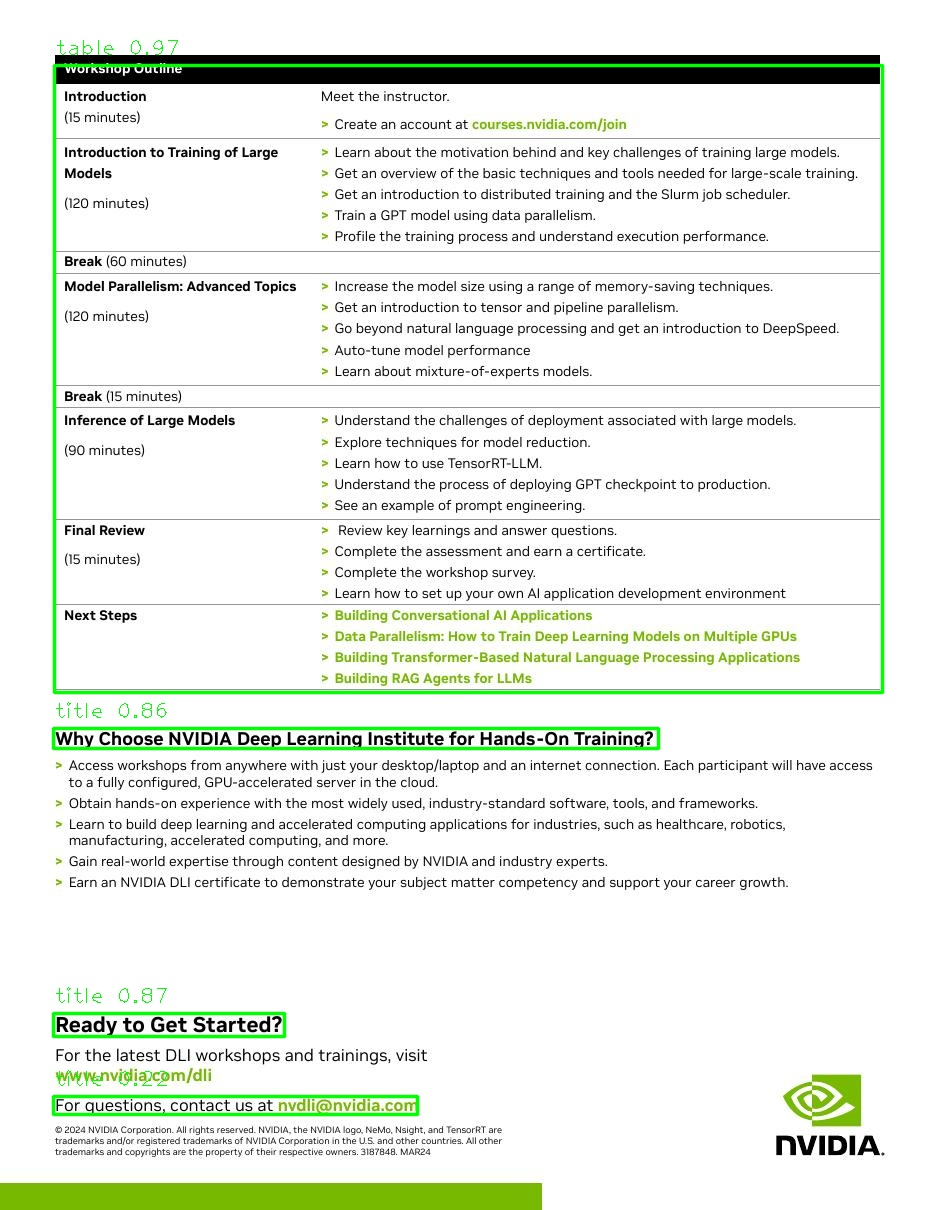

In [33]:
IPyImage(filename=OUTPUT_IMAGE_PATH + '/annotated_test_1.jpg', width=600)

## 3.6 端到端多模态数据提取

现在我们已经看到了几种预处理多模态 PDF 的不同方法，下面可以试试另一个端到端示例。

这有一篇论文 [ChipNemo](https://arxiv.org/pdf/2311.00176)：

In [34]:
IFrame("ocr/pdfs/ChipNeMo.pdf", width=800, height=500)

PDF 包含不同章节下的文本、图形、表格和图表的组合。

如果需要定义一种方法来处理一个 PDF 文件夹中的每个文件。可以通过 `partition_pdf` 的不同设置进行控制。

比如 `strategy` 设为 `hi_res` 能根据文档格式精细地识别元素类型，是该库[推荐的](https://docs.unstructured.io/api-reference/partition/partitioning)基于模型的策略。
另一个参数 `extract_images_in_pdf`, 如果设为 `True`，就会将文件中的图像提取出来，若设为 `False` 或不设置（默认为 `False`）则忽略图像，仅提取文本和表格数据。

下面我们先试试不设置 `extract_images_in_pdf`，仅提取文本和表格：

In [35]:
class ExtractionPipeline:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.pdf_filenames = self.get_pdf_filenames_from_folder()        

    def get_pdf_filenames_from_folder(self):
        return list(Path(self.folder_path).glob("*.pdf"))

    def load_and_split_documents(self):
        for pdf_filename in self.pdf_filenames:
            print("processing document: ", pdf_filename)
            raw_pdf_elements = partition_pdf(
                pdf_filename, 
                infer_table_structure=True, 
                strategy='hi_res'
            )

            Text_elements = [Document(page_content=e.text.strip(), metadata={"filename": e.metadata.filename, "source_type": "text"}) for e in raw_pdf_elements if type(e) == Text or CompositeElement]
            print("Number of Detected Text elements: ", len(Text_elements))

            Table_elements = [Document(page_content=e.metadata.text_as_html, metadata={"filename": e.metadata.filename, "source_type": "table_html"}) for e in raw_pdf_elements if type(e) == Table]
            print("Number of Detected HTML Tables: ", len(Table_elements))

        return Text_elements, Table_elements

现在调用提取功能。它将借助 `hi_res` 策略提取文件夹中所有 PDF 的文本和表格（HTML格式）。我们设置了如 `max_characters`、`new_after_n_chars` 和 `combine_text_under_n_chars` 等参数，用来控制文本元素的块大小。

In [36]:
PDF_FOLDER_PATH = "ocr/pdfs"
Extraction_pipeline = ExtractionPipeline(folder_path=PDF_FOLDER_PATH)

<div class="alert alert-warning">运行下一个单元可能需要大约 3 分钟。</div>

In [ ]:
%%time 
# 2min 42s if you use default, 2s if you use fast but you get only text (no tabular data)
Text_elements, Table_elements = Extraction_pipeline.load_and_split_documents()

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


processing document:  ocr/pdfs/ChipNeMo.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

来验证一下结果：

In [ ]:
Text_elements[0].page_content, Text_elements[0].metadata

In [ ]:
Table_elements[0].page_content, Table_elements[0].metadata

最后，我们可以通过 [pickle](https://docs.python.org/3/library/pickle.html) 将提取的数据存到假设的 RAG 数据库里。

In [ ]:
# save text and HTML tables 
import pickle

PATH_DATA = "ocr/outputs/data_dir_extracted"

with open(PATH_DATA + '/tables_db.pkl', 'wb') as fp:
    pickle.dump(Table_elements, fp)

with open(PATH_DATA + '/text_db.pkl', 'wb') as fp:
    pickle.dump(Text_elements, fp)

在保存论文的所有文本和表格信息后，接下来可以试试将 `extract_images_in_pdf` 设为 `True`，提取文件中的图片：

In [ ]:


class VisualExtractionPipeline:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.pdf_filenames = self.get_pdf_filenames_from_folder()        

    def get_pdf_filenames_from_folder(self):
        return list(Path(self.folder_path).glob("*.pdf"))

    def load_and_split_documents(self):
        for pdf_filename in self.pdf_filenames:
            print("processing document: ", pdf_filename)
            image_text_elements = partition_pdf(
                filename=pdf_filename,
                strategy="hi_res",
                hi_res_model_name="yolox",
                extract_images_in_pdf=True,
                extract_image_block_types=["Image"],
                extract_image_block_to_payload=False,
                extract_image_block_output_dir="ocr/figures"
            )
        image_elements = [Document(page_content=e.metadata.image_path, metadata={"filename": e.metadata.filename, "source_type": "image"}) for e in image_text_elements if type(e) is Image]
        return image_elements

<div class="alert alert-warning">运行下一个单元可能需要大约 2-3 分钟。</div>

In [42]:
%%time
Extraction_pipeline_visual = VisualExtractionPipeline(folder_path=PDF_FOLDER_PATH)
image_elements = Extraction_pipeline_visual.load_and_split_documents()

CPU times: user 8min 48s, sys: 596 ms, total: 8min 49s
Wall time: 1min 19s


现在来看看从 PDF 提取出来的图片：

In [43]:
images = [e.page_content for e in image_elements]
plot_images_from_folder(image_files=images)

和之前一样，我们可以把数据存到虚构的数据库中。

In [44]:
# save text and HTML tables 
import pickle

PATH_DATA = "ocr/outputs/data_dir_extracted"

with open(PATH_DATA + '/images_db.pkl', 'wb') as fp:
    pickle.dump(image_elements, fp)

## 下一步
恭喜您走到了最后！

在这个 notebook 中，我们：
- 使用 *Unstructured* 库对多模态 PDF 进行了预处理，这是创建多模态 RAG 工作流的第一步，并探索了各种提取文本、表格、图像和图表的功能。
- 研究了为多模态内容提取设计的 NIMs 组件，以简化流程。

课程的下个部分将给出完整的视频搜索和摘要（VSS）编排工作流。